# TensorFlow Tutorial
# CFAR-10

by [David Ohm](http://ohmdsp.github.io/)
/ [GitHub](https://github.com/ohmdsp)

## Introduction

This tutorial shows how to implement a Convolutional Neural Network in TensorFlow for classification. We will explore classification using the CFAR-10 dataset. This tutorial heavily influence by the tutorials by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

There are several builder API's available for TensorFlow (e.g., Layers API, Keras API). This tutorial uses the Keras API which is highly developed with very good documentation.

## Processing Workflow

The chart below (by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)) shows the approximate data flow through the Convolutional Neural Network implemented in this tutorial. 

The network has a pre-processing layer that augments the input images to inflate the training-set. The network has two convolutional layers, two fully-connected layers and a softmax classification layer.

![Flowchart](images/06_network_flowchart.png)

## Import required libraries and packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import keras

Using TensorFlow backend.


In [2]:
plt.rcParams["figure.figsize"] = (12,8)   # set plot sizes

We need to also import several useful tools from Keras.

In [3]:
# from tf.keras.models import Sequential  # This does not work!
#from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Activation, Dropout

Check your TensorFlow version (should be 1.9 or greater).

In [4]:
tf.__version__

'1.14.0-rc1'

## Load CFAR-10 Data

Use imported functions for downloading the cifar10 dataset.

In [5]:
import cifar10_tools

In [6]:
cifar10_tools.data_path = "/data/cifar10/"

In [7]:
class_names = cifar10_tools.load_class_names()
class_names

Loading data: /data/cifar10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
images_train, cls_train, labels_train = cifar10_tools.load_training_data()

Loading data: /data/cifar10/cifar-10-batches-py/data_batch_1
Loading data: /data/cifar10/cifar-10-batches-py/data_batch_2
Loading data: /data/cifar10/cifar-10-batches-py/data_batch_3
Loading data: /data/cifar10/cifar-10-batches-py/data_batch_4
Loading data: /data/cifar10/cifar-10-batches-py/data_batch_5


In [9]:
images_test, cls_test, labels_test = cifar10_tools.load_test_data()

Loading data: /data/cifar10/cifar-10-batches-py/test_batch


In [10]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [11]:
# If using keras to extract the cifar-10 data you can use this. However, it will not 
# provide the features the code in the next box does.
# The data, split between train and test sets:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#print('x_train shape:', x_train.shape)
#print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

In [12]:
x_train = images_train
x_test = images_test
y_train = labels_train.astype('float32')
y_test = labels_test.astype('float32')

print('x_train shape:', images_train.shape)
print(images_train.shape[0], 'train samples')
print(images_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [13]:
from cifar10_tools import img_size, num_channels, num_classes

Setup some parameters for processing.

In [14]:
batch_size = 30
epochs = 10
data_augmentation = True
num_predictions = 20
img_shape = (img_size,img_size, num_channels)
save_dir = '/data/cifar10/cifar-10/cfarsaved_models'
model_name = 'keras_cifar10_trained_model.h5'

In [15]:
#(Do Not use)
# Convert class vectors to binary class matrices (one-hot encoding).
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

### Helper-function for plotting images

Function used to plot 16 images in a 4x4 grid.

In [16]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 16

    # Create figure with sub-plots.
    fig, axes = plt.subplots(4, 4)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.4
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        #print('class_true_name = ' ,class_names[cls_true[i]])
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            #print('cls_pred_name = ' ,class_names[cls_pred[i]])
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

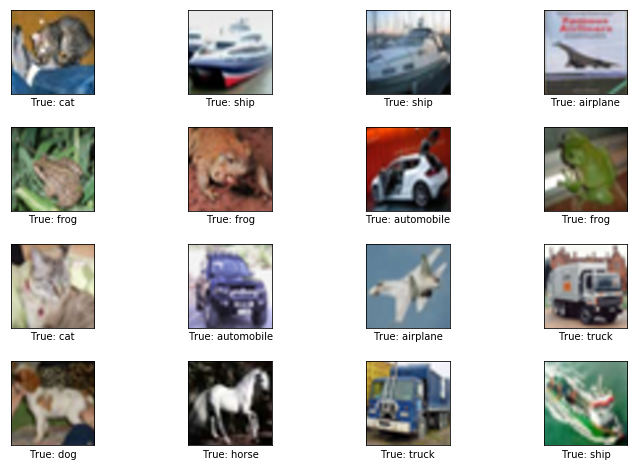

In [17]:
# Get the first images from the test-set.
images = images_test[0:16]

# Get the true classes for those images.
cls_true = cls_test[0:16]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)


## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can calculate the gradients that are needed to optimize the graph. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

A TensorFlow graph consists of the following parts which will be detailed below:

* Model
* Variables to be optimized
* A loss function
* An optimization method

## Sequential Model

The Keras API has two modes of constructing Neural Networks. The simplest is the Sequential Model allows layers to be added in sequence.

In [18]:
# 2-block VGG style of network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='valid',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Conv2D(128, (3, 3),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
# output section of model
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         7

### Model Compilation

The Neural Network has now been defined.We need to add a loss-function, optimizer and appropriate performance metrics. This is called model "compilation" in Keras.

In [20]:
#from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.optimizers import SGD

#optimizer = Adam(lr=1e-3)  # lr = learning rate for the optimizer
optimizer = SGD(lr=0.001, momentum=0.9)

For a classification-problem we will use the loss-function called `categorical_crossentropy`. The performance metric we are interested in is the classification accuracy.

In [21]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

Now that the model has been fully defined with a loss-function and optimizer, we can train it. Training will will be done using a defined number of training epochs using a given batch-size (defined above). An epoch is one full use of the entire training-set. So for 100 epochs we would iterate randomly over the entire training-set 100 times. Notice that we also normalize the training data.

In [22]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do pre-processing and real-time data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    #history = model.fit_generator(datagen.flow(x_train, y_train,
    #                                 batch_size=batch_size),
    #                    epochs=epochs,
    #                    validation_data=(x_test, y_test),
    #                    workers=4)
    
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test), verbose=1)


Using real-time data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 4s 86us/sample - loss: 2.2010 - acc: 0.1899 - val_loss: 2.0030 - val_acc: 0.2654
Epoch 2/30
50000/50000 [==============================] - 3s 66us/sample - loss: 1.9184 - acc: 0.2955 - val_loss: 1.7949 - val_acc: 0.3449
Epoch 3/30
50000/50000 [==============================] - 3s 65us/sample - loss: 1.7155 - acc: 0.3762 - val_loss: 1.8654 - val_acc: 0.3294
Epoch 4/30
50000/50000 [==============================] - 3s 66us/sample - loss: 1.5662 - acc: 0.4346 - val_loss: 1.4839 - val_acc: 0.4676
Epoch 5/30
50000/50000 [==============================] - 3s 66us/sample - loss: 1.4734 - acc: 0.4683 - val_loss: 1.4771 - val_acc: 0.4762
Epoch 6/30
50000/50000 [==============================] - 3s 66us/sample - loss: 1.3863 - acc: 0.5034 - val_loss: 1.3881 - val_acc: 0.5106
Epoch 7/30
50000/50000 [==============================] - 3s 65us/sample - loss: 

### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [23]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /data/cifar10/cifar-10/cfarsaved_models/keras_cifar10_trained_model.h5 


Or we can just print the classification accuracy.

In [24]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 63us/sample - loss: 0.9425 - acc: 0.6865
Test loss: 0.9425019017219544
Test accuracy: 0.6865


In [25]:
# plot diagnostic learning curves
import sys
from matplotlib import pyplot
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.legend(loc='upper left')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    pyplot.legend(loc='upper left')
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    pyplot.close()

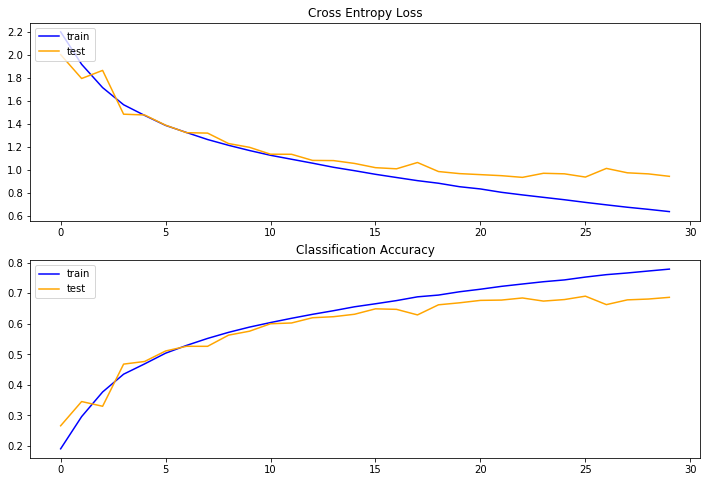

In [26]:
# learning curves
summarize_diagnostics(history)

We can see the model start to overfit at about 15-20 epochs into the training. This is indicated by the training loss going down, but the test loss starting to go up. We can go back and reduce the number of training epochs to approximately 25 and then experiment with differnet model parameters and archetechtures to see what improvement is possible. 

### Prediction

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [27]:
images = x_test[0:16]

These are the true class-number for those images. This is only used when plotting the images.

In [28]:
cls_true = cls_test[0:16]
cls_true

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])

Get the predicted classes as integers.

In [29]:
cls_pred = model.predict_classes(x=images)
cls_pred

array([3, 8, 8, 0, 4, 6, 1, 6, 5, 1, 4, 9, 5, 7, 9, 8])

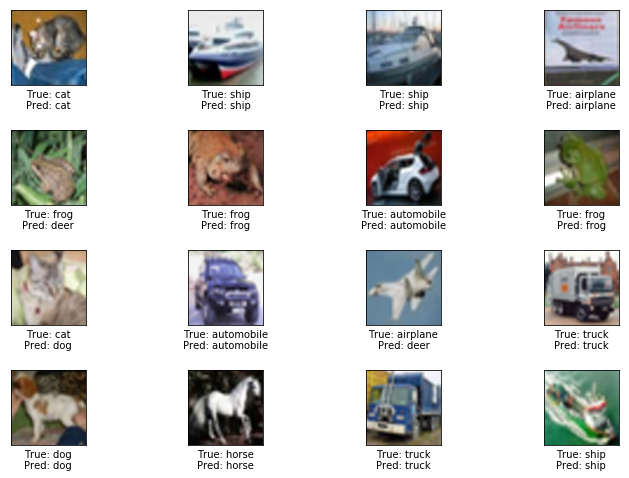

In [30]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [31]:
y_pred = model.predict(x=x_test)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [32]:
cls_pred = np.argmax(y_pred, axis=1)

Function for plotting some of the mis-classified images.

In [33]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:16],
                cls_true=cls_true[0:16],
                cls_pred=cls_pred[0:16])

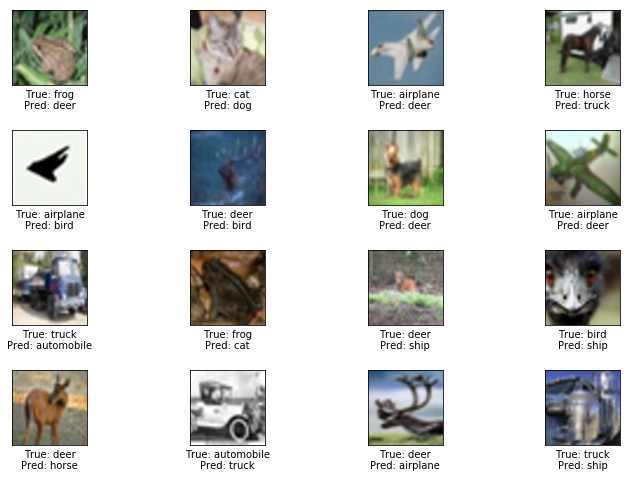

In [34]:
plot_example_errors(cls_pred)

## Building a Functional Model
We can also create a functional model using the keras API. This is important if we ever want to return multiple outputs. 

In [35]:
layers = tf.keras.layers
activations = tf.keras.activations

def cfarnet():
    inputs = tf.keras.Input([32, 32, 3], dtype=tf.float32)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="valid")(inputs)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid")(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="valid")(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(x)
    x = layers.Flatten()(x)  # new size is 32*3*3=288
    x = layers.Dense(256)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(128)(x)
    x = layers.ReLU()(x)
    
    cfar_cls = layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=[cfar_cls], name="cfarnet_cls")
    
    return model


In [36]:
model3 = cfarnet()

In [37]:
model3.summary()

Model: "cfarnet_cls"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
re_lu (ReLU)                 (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          

In [38]:
#from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.optimizers import SGD

#optimizer = Adam(lr=1e-3)  # lr = learning rate for the optimizer
optimizer = SGD(lr=0.001, momentum=0.9)

In [39]:
model3.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do pre-processing and real-time data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    #history = model.fit_generator(datagen.flow(x_train, y_train,
    #                                 batch_size=batch_size),
    #                    epochs=epochs,
    #                    validation_data=(x_test, y_test),
    #                    workers=4)
    

history = model3.fit(x_train, y_train, 
                    epochs=epochs, batch_size=128, 
                    validation_data=(x_test, y_test), verbose=1)

Using real-time data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 2s 48us/sample - loss: 2.2839 - acc: 0.1594 - val_loss: 2.2540 - val_acc: 0.1930
Epoch 2/30
50000/50000 [==============================] - 2s 45us/sample - loss: 2.1335 - acc: 0.2359 - val_loss: 1.9929 - val_acc: 0.2689
Epoch 3/30
50000/50000 [==============================] - 2s 44us/sample - loss: 1.9467 - acc: 0.2870 - val_loss: 1.9099 - val_acc: 0.3008
Epoch 4/30
50000/50000 [==============================] - 2s 44us/sample - loss: 1.8431 - acc: 0.3281 - val_loss: 1.7543 - val_acc: 0.3724
Epoch 5/30
50000/50000 [==============================] - 2s 44us/sample - loss: 1.7254 - acc: 0.3774 - val_loss: 1.7313 - val_acc: 0.3775
Epoch 6/30
50000/50000 [==============================] - 2s 43us/sample - loss: 1.6379 - acc: 0.4093 - val_loss: 1.5864 - val_acc: 0.4293
Epoch 7/30
50000/50000 [==============================] - 2s 44us/sample - loss: 

In [41]:
# Score trained model.
scores = model3.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 59us/sample - loss: 1.0979 - acc: 0.6179
Test loss: 1.0978547429084777
Test accuracy: 0.6179


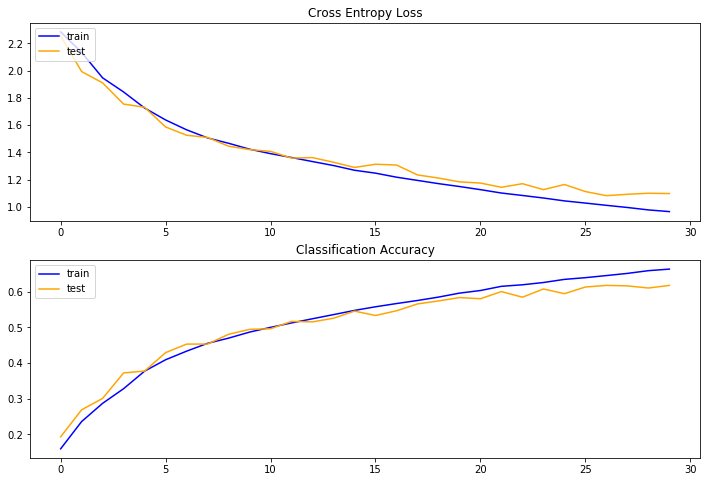

In [42]:
# learning curves
summarize_diagnostics(history)

## Loading a Saved Model

NOTE: You need to install `h5py` for this to work!
It is worth learning how to load the model that was saved previously.
This is the file-path where we want to save the Keras model.

In [43]:
path_model = '/data/cifar10/cifar-10/cfarsaved_models/'

Delete the previously used sequential model from memory so we are sure it is no longer used.

In [44]:
del model

We need to import this Keras function for loading the model.

In [45]:
from tensorflow.python.keras.models import load_model

Loading the model is then just a single function-call, as it should be.

In [46]:
model2 = load_model(path_model + model_name)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


We can then use the model again e.g. to make predictions. We get the first 16 images from the test-set and their true class-numbers.

In [47]:
images = x_test[0:16]

In [48]:
cls_true = cls_test[0:16]

We then use the restored model to predict the class-numbers for those images.

In [49]:
y_pred = model2.predict(x=images)

Get the class-numbers as integers.

In [50]:
cls_pred = np.argmax(y_pred, axis=1)

Plot the images with their true and predicted class-numbers.

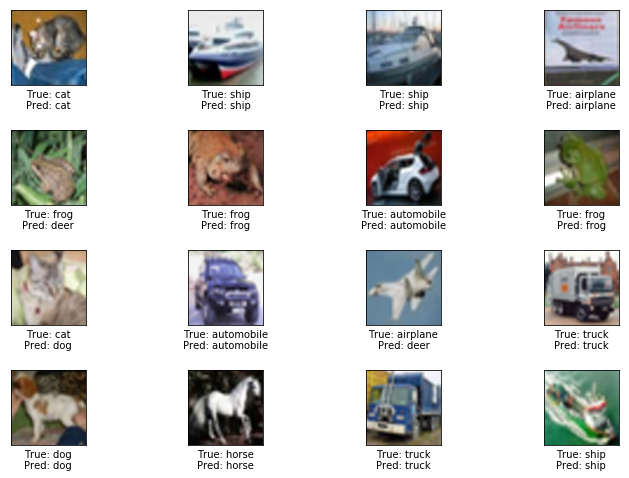

In [51]:
plot_images(images=images,
            cls_pred=cls_pred,
            cls_true=cls_true)

## Visualization of Layer Weights and Outputs

### Helper-function for plotting convolutional weights

In [52]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Get Layers

Keras has a simple way of listing the layers in the model.

In [53]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         7

We count the indices to get the layers we want.
The first convolutional layer has index 0.

In [54]:
layer_conv1 = model2.layers[0]
layer_conv1

The second convolutional layer has index 2.

In [55]:
layer_conv2 = model2.layers[3]
layer_conv2

### Convolutional Weights

Now that we have the layers we can easily get their weights.

In [56]:
weights_conv1 = layer_conv1.get_weights()[0]

This gives us a 4-rank tensor.

In [57]:
weights_conv1.shape

(3, 3, 3, 32)

Plot the weights using the helper-function from above.

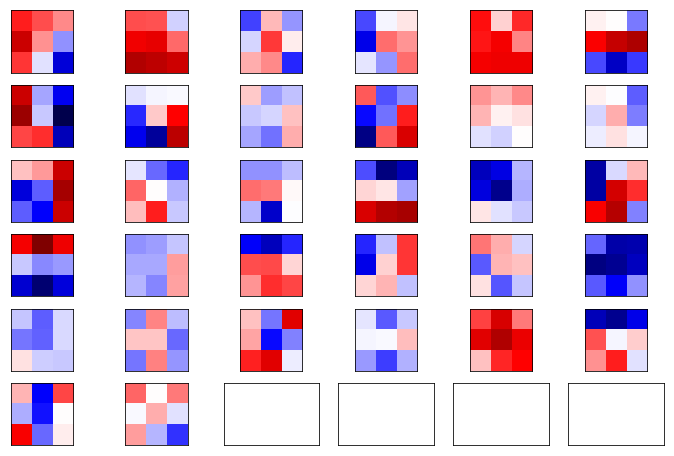

In [58]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

We can also get the weights for the second convolutional layer and plot them.

In [59]:
weights_conv2 = layer_conv2.get_weights()[0]

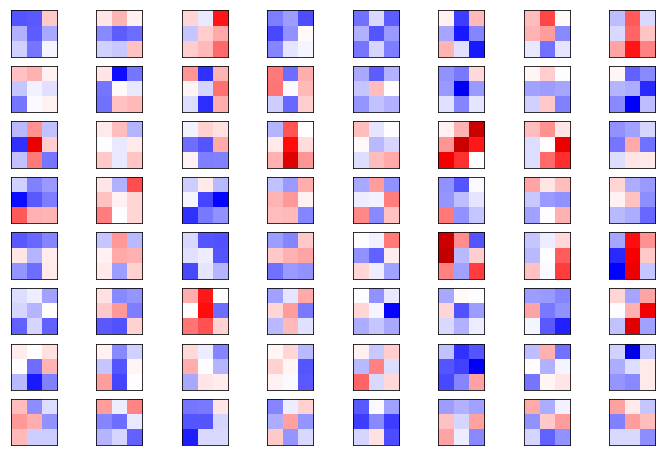

In [60]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

### Function for plotting the output of a convolutional layer

In [61]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Image

Function for plotting a single image.

In [62]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

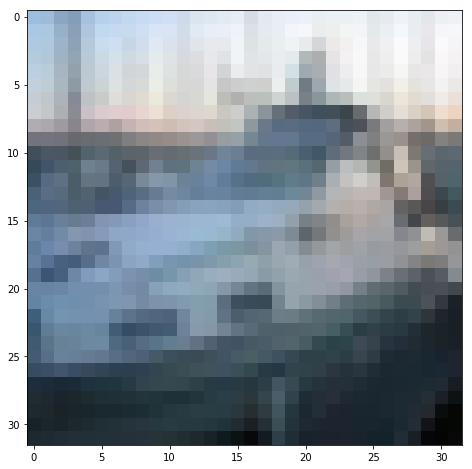

In [73]:
image1 = x_test[2]
plot_image(image1)

### Output of Convolutional Layer

There are different ways of getting the output of a layer in a Keras model.

In [124]:
from tensorflow.python.keras import backend as K

In [125]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         7

In [126]:
#output_conv1 = K.function(inputs=[model2.layers[0].input],
#                          outputs=[model2.layers[3].output])

In [127]:
image1.shape

(32, 32, 3)

In [128]:
image1r = np.resize(image1, (1,32,32,3))
image1r.shape

(1, 32, 32, 3)

In [131]:
from tensorflow.python.keras.models import Model
model = model2
layer_name = 'activation'
layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [132]:
layer1_output = layer_model.predict(image1r)

We can then plot the output of all 32 channels of the convolutional layer.

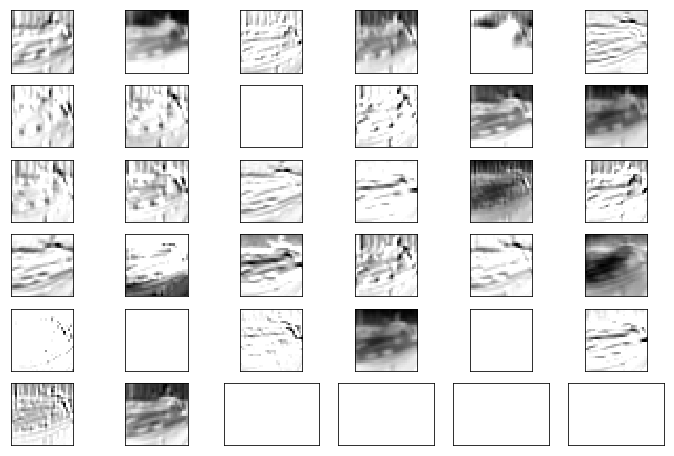

In [133]:
plot_conv_output(values=layer1_output)

## Conclusion

This notebook showed how to use the *TensorFlow Keras API* for creating Convolutional Neural Networks. It also showed how to save and load a model, as well as visualizing the weights and outputs of convolutional layers.

## Things to Try

These are a few suggestions for things to try:

* Train for more epochs. Does it improve the classification accuracy?
* Change some of the layers and retrain.
* Change some layer parameters and retrain.
* Add and remove some convolutional and fully-connected layers and retrain.
* What is the simplest network you can create that still performs well?

In [ ]:
# You can enter more code here.